In [18]:
import os
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# put image data into a numpy array
def preprocess_data(img_dir):

    images = []
    labels = []

    img_data = pd.read_csv('Data_Entry_2017_v2020.csv')

    # loop through images
    i = 1
    for img_file in tqdm(os.listdir(img_dir), desc=f"loading images"):

        # save them as numpy arrau
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert('RGB') # 3 channels to match ImageNet


        img = tf.image.resize(img, [32, 32])

        img = tf.image.random_contrast(img, lower=0.8, upper=1.2) 
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_flip_left_right(img)

        # normalize the image to the range [0, 1]
        img = tf.cast(img, tf.float32) / 255.0

        # apply ImageNet normalization: (image - mean) / std
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = (img - mean) / std

        # add random noise
        noise = tf.random.uniform(shape=tf.shape(img), minval=0, maxval=1, dtype=tf.float32)
        img = tf.where(noise < 0.05 / 2, 0.0, tf.where(noise < 0.05, 1.0, img))

        images.append(img)

        # get label
        label = img_data.loc[img_data['Image Index'] == img_file, 'Finding Labels'].values[0]
        labels.append(label)

        i += 1

    # encode labels )numericaly
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    return np.array(images), np.array(labels)

In [3]:
images, labels = preprocess_data('images')
num_classes = len(set(labels))

images = images.reshape(images.shape[0], -1).astype(float)

# split data into training and testing sets (e.g., 80% train, 20% test)
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

loading images: 100%|██████████| 11700/11700 [03:54<00:00, 49.88it/s]


In [5]:
# def hyperparameter_tuning(model, params, k_folds=5):
#     k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
#     grid_search = GridSearchCV(estimator=model, param_grid=params, cv=k_fold, scoring='accuracy', verbose=3, n_jobs=-1)

#     grid_search.fit(x_train, y_train)

#     # Best parameters
#     print("Best Parameters:", grid_search.best_params_)
#     print("Best Score:", grid_search.best_score_)

#     return grid_search.best_params_, grid_search.best_score_

In [ ]:
# svm = SVC()

# param_grid_svm = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear','poly', 'rbf']
# }

# params_svm, score_svm = hyperparameter_tuning(svm, param_grid_svm, 5)
# print(f"Best Params: {params_svm}")
# print(f"Best Score: {score_svm}")

In [ ]:
# rf = RandomForestClassifier()

# param_grid_rf = {
#     'n_estimators': [100, 200, 500, 100],
#     'max_depth': [None, 10, 20, 30]
# }

# params_rf, score_rf = hyperparameter_tuning(rf, param_grid_rf, 5)
# print(f"Best Params: {params_rf}")
# print(f"Best Score: {score_rf}")

In [ ]:
# knn = KNeighborsClassifier()

# param_grid_knn = {
#     'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]
# }

# params_knn, score_knn = hyperparameter_tuning(knn, param_grid_knn, 5)
# print(f"Best Params: {params_knn}")
# print(f"Best Score: {score_knn}")

In [ ]:
# xgb = XGBClassifier()

# param_grid_xgb = {
#     'n_estimators': [100, 200, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2]
# }

# params_xgb, score_xgb = hyperparameter_tuning(xgb, param_grid_xgb, 5)
# print(f"Best Params: {params_xgb}")
# print(f"Best Score: {score_xgb}")

In [19]:
svm = SVC()

svm.fit(x_train, y_train)

y_val_pred = svm.predict(x_val)
svm_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", svm_val_acc)

y_test_pred = svm.predict(x_test)
svm_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", svm_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.24017094017094018
Test Accuracy: 0.24700854700854702
Test Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.34      0.31       131
           1       0.27      0.24      0.26       127
           2       0.18      0.19      0.19       140
           3       0.24      0.32      0.27       115
           4       0.23      0.33      0.27       123
           5       0.16      0.08      0.10       132
           6       0.23      0.16      0.19       124
           7       0.28      0.27      0.28       138
           8       0.31      0.31      0.31       140

    accuracy                           0.25      1170
   macro avg       0.24      0.25      0.24      1170
weighted avg       0.24      0.25      0.24      1170



In [20]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)

y_val_pred = rf.predict(x_val)
rf_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", rf_val_acc)

y_test_pred = rf.predict(x_test)
rf_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", rf_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.2230769230769231
Test Accuracy: 0.23504273504273504
Test Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.26      0.25       131
           1       0.27      0.31      0.29       127
           2       0.20      0.20      0.20       140
           3       0.19      0.29      0.23       115
           4       0.22      0.28      0.24       123
           5       0.17      0.09      0.12       132
           6       0.19      0.15      0.17       124
           7       0.28      0.27      0.27       138
           8       0.34      0.27      0.30       140

    accuracy                           0.24      1170
   macro avg       0.23      0.24      0.23      1170
weighted avg       0.24      0.24      0.23      1170



In [21]:
knn = KNeighborsClassifier()

knn.fit(x_train, y_train)

y_val_pred = knn.predict(x_val)
knn_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", knn_val_acc)

y_test_pred = knn.predict(x_test)
knn_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", knn_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.16153846153846155
Test Accuracy: 0.19658119658119658
Test Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.48      0.29       131
           1       0.17      0.24      0.20       127
           2       0.17      0.16      0.17       140
           3       0.22      0.29      0.25       115
           4       0.21      0.18      0.19       123
           5       0.17      0.11      0.13       132
           6       0.15      0.09      0.11       124
           7       0.19      0.12      0.15       138
           8       0.30      0.12      0.17       140

    accuracy                           0.20      1170
   macro avg       0.20      0.20      0.18      1170
weighted avg       0.20      0.20      0.18      1170



In [22]:
xgb = XGBClassifier()

xgb.fit(x_train, y_train)

y_val_pred = xgb.predict(x_val)
xgb_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", xgb_val_acc)

y_test_pred = xgb.predict(x_test)
xgb_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", xgb_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.20683760683760682
Test Accuracy: 0.24957264957264957
Test Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.32      0.29       131
           1       0.21      0.17      0.19       127
           2       0.26      0.23      0.24       140
           3       0.22      0.29      0.25       115
           4       0.23      0.31      0.27       123
           5       0.24      0.19      0.21       132
           6       0.24      0.22      0.23       124
           7       0.29      0.29      0.29       138
           8       0.28      0.24      0.26       140

    accuracy                           0.25      1170
   macro avg       0.25      0.25      0.25      1170
weighted avg       0.25      0.25      0.25      1170



In [23]:
lr = LogisticRegression()

lr.fit(x_train, y_train)

y_val_pred = lr.predict(x_val)
lr_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", lr_val_acc)

y_test_pred = lr.predict(x_test)
lr_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", lr_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.1658119658119658
Test Accuracy: 0.1623931623931624
Test Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.19      0.18       131
           1       0.16      0.13      0.14       127
           2       0.15      0.16      0.16       140
           3       0.16      0.21      0.18       115
           4       0.18      0.20      0.19       123
           5       0.09      0.09      0.09       132
           6       0.19      0.18      0.18       124
           7       0.19      0.17      0.18       138
           8       0.18      0.15      0.16       140

    accuracy                           0.16      1170
   macro avg       0.16      0.16      0.16      1170
weighted avg       0.16      0.16      0.16      1170



/opt/anaconda3/envs/MATH452/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
nb = GaussianNB()

nb.fit(x_train, y_train)

y_val_pred = nb.predict(x_val)
nb_val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", nb_val_acc)

y_test_pred = nb.predict(x_test)
nb_test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", nb_test_acc)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.19914529914529913
Test Accuracy: 0.2
Test Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.44      0.30       131
           1       0.18      0.21      0.19       127
           2       0.19      0.28      0.23       140
           3       0.21      0.21      0.21       115
           4       0.21      0.21      0.21       123
           5       0.08      0.01      0.01       132
           6       0.14      0.03      0.05       124
           7       0.20      0.17      0.19       138
           8       0.19      0.22      0.21       140

    accuracy                           0.20      1170
   macro avg       0.18      0.20      0.18      1170
weighted avg       0.18      0.20      0.18      1170



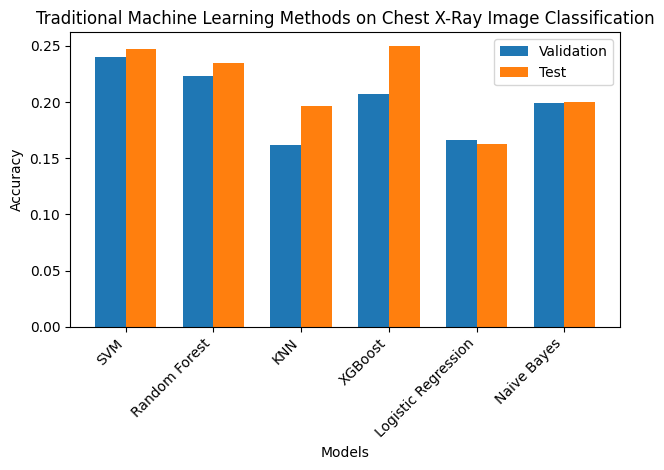

In [28]:
categories = ['SVM', 'Random Forest', 'KNN', 'XGBoost', 'Logistic Regression', 'Naive Bayes']
validation_accuracies = [svm_val_acc, rf_val_acc, knn_val_acc, xgb_val_acc, lr_val_acc, nb_val_acc]
test_accuracies = [svm_test_acc, rf_test_acc, knn_test_acc, xgb_test_acc, lr_test_acc, nb_test_acc]

bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index - bar_width / 2, validation_accuracies, bar_width, label='Validation')
plt.bar(index + bar_width / 2, test_accuracies, bar_width, label='Test')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Traditional Machine Learning Methods on Chest X-Ray Image Classification')
plt.xticks(index, categories, rotation=45, ha='right', va='top')
plt.legend()
plt.tight_layout()
plt.show()
